In [1]:
import os
import umap
import torch
import itertools
from core import *
import numpy as np
import pandas as pd
import pickle as pkl
from torch import nn
import os.path as op
from tqdm import tqdm
from time import time
from copy import deepcopy
from torch.optim import Adam
from tpot import TPOTRegressor
import torch.nn.functional as F
import matplotlib.pyplot as plt
from capsules.capsules import *
from IPython.display import Image
from qhoptim.pyt import QHM, QHAdam
from matplotlib.lines import Line2D
from torch.autograd import Variable
from matplotlib.patches import Patch
from scipy.stats import spearmanr, pearsonr
from catboost import CatBoostRegressor, Pool, cv
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error
from sklearn.metrics import accuracy_score, matthews_corrcoef, precision_score, recall_score

/home/bakirillov/.local/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/home/bakirillov/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/bakirillov/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selectio

In [2]:
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset

In [3]:
import gpytorch
from gpytorch.means import ConstantMean, LinearMean
from gpytorch.models import ApproximateGP, ExactGP 
from sklearn.metrics import accuracy_score
from gpytorch.priors import SmoothedBoxPrior
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.kernels import ScaleKernel, RBFKernel, GridInterpolationKernel
from gpytorch.mlls import VariationalELBO, VariationalELBOEmpirical, DeepApproximateMLL
from gpytorch.distributions import MultivariateNormal
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy
from gpytorch.models.deep_gps import DeepGPLayer, DeepGP

In [4]:
DATAPATH = "/home/bakirillov/HDD/data/genomes/all_guides_chr22.tsv"
ANNOTATION = "/home/bakirillov/HDD/data/genomes/annotation.csv"

In [5]:
annotation = pd.read_csv(ANNOTATION, header=1)[["Start", "Stop", "Gene symbol"]]
annotation = list(
    zip(
        annotation["Start"].values, annotation["Stop"].values, 
        annotation["Gene symbol"].values
    )
)

In [6]:
transformer = get_Cas9_transformer(True)

In [7]:
cnn_mse_encoder = GuideHN(21, 32, 1360, n_classes=5).cuda()
cnn_mse = DKL(cnn_mse_encoder, [1,5*32]).cuda()
cnn_mse.load_state_dict(torch.load("../models/DeepHF/Wt/cnn_mse59.ptch"))

<All keys matched successfully>

In [8]:
rnn_mse_encoder = GuideHRNN(21, 32, 3360, n_classes=5).cuda()
rnn_mse = DKL(rnn_mse_encoder, [1,5*32]).cuda()
rnn_mse.load_state_dict(torch.load("../models/DeepHF/Wt/rnn_mse59.ptch"))

<All keys matched successfully>

In [9]:
cnn_elbo_encoder = GuideHN(21, 32, 1360, n_classes=5).cuda()
cnn_elbo = DKL(cnn_elbo_encoder, [1,5*32]).cuda()
cnn_elbo.load_state_dict(torch.load("../models/DeepHF/Wt/cnn_elbo59.ptch"))

<All keys matched successfully>

In [10]:
rnn_elbo_encoder = GuideHRNN(21, 32, 3360, n_classes=5).cuda()
rnn_elbo = DKL(rnn_elbo_encoder, [1,5*32]).cuda()
rnn_elbo.load_state_dict(torch.load("../models/DeepHF/Wt/rnn_elbo59.ptch"))

<All keys matched successfully>

In [11]:
with open("DeepHF_wt_filtered.tsv", "w") as oh:
    with open(DATAPATH, "r") as ih:
        for a in tqdm(ih):
            cur = a.split("\t")[2:-1]
            is_in_gene = [(start <= int(cur[0]) and int(cur[0]) <= stop, gene) for start,stop,gene in annotation]
            what = list(filter(lambda x: x[0], is_in_gene))
            if len(what) > 0:
                oh.write(a.replace("\n", "")+"\t"+what[0][-1]+"\n")

5295100it [1:04:54, 1359.72it/s]


In [12]:
out = open("DeepHF_wt.tsv", "a")

In [13]:
i = 0
b = 0
zero = False
with open("DeepHF_wt_filtered.tsv", "r") as oh:
    while True:
        current_batch = []
        try:
            for a in np.arange(1024):
                cur = oh.readline()
                if len(cur) != 0:
                    cur = cur.split("\t")[2:]
                    current_batch.append(cur)
                else:
                    zero = True
                    break
            current_batch = np.array(current_batch)
            transformed_batch = torch.stack([transformer(a) for a in current_batch.T[1]])
            tb_cnn_mse = cnn_mse(transformed_batch)
            tb_cnn_mse_o = cnn_mse.likelihood(
                tb_cnn_mse[0]
            ).mean.mean(0).cpu().data.numpy()
            tb_cnn_mse_v = cnn_mse.likelihood(
                tb_cnn_mse[0]
            ).variance.mean(0).cpu().data.numpy()
            tb_rnn_mse = rnn_mse(transformed_batch)
            tb_rnn_mse_o = rnn_mse.likelihood(
                tb_rnn_mse[0]
            ).mean.mean(0).cpu().data.numpy()
            tb_rnn_mse_v = rnn_mse.likelihood(
                tb_rnn_mse[0]
            ).variance.mean(0).cpu().data.numpy()
            tb_cnn_elbo = cnn_elbo(transformed_batch)
            tb_cnn_elbo_o = cnn_elbo.likelihood(
                tb_cnn_elbo[0]
            ).mean.mean(0).cpu().data.numpy()
            tb_cnn_elbo_v = cnn_elbo.likelihood(
                tb_cnn_elbo[0]
            ).variance.mean(0).cpu().data.numpy()
            tb_rnn_elbo = rnn_elbo(transformed_batch)
            tb_rnn_elbo_o = rnn_elbo.likelihood(
                tb_rnn_elbo[0]
            ).mean.mean(0).cpu().data.numpy()
            tb_rnn_elbo_v = rnn_elbo.likelihood(
                tb_rnn_elbo[0]
            ).variance.mean(0).cpu().data.numpy()
            for a,c1m,c1v,r1m,r1v,c2m,c2v,r2m,r2v in zip(
                current_batch, tb_cnn_mse_o, tb_cnn_mse_v,
                tb_rnn_mse_o, tb_rnn_mse_v, 
                tb_cnn_elbo_o, tb_cnn_elbo_v,
                tb_rnn_mse_o, tb_rnn_mse_v
            ):
                out.write("\t".join(a).replace("\n", ""))
                out.write(
                    "\t"+str(c1m)
                )
                out.write(
                    "\t"+str(c1v)
                )
                out.write(
                    "\t"+str(r1m)
                )
                out.write(
                    "\t"+str(r1v)
                )
                out.write(
                    "\t"+str(c2m)
                )
                out.write(
                    "\t"+str(c2v)
                )
                out.write(
                    "\t"+str(c2m)
                )
                out.write(
                    "\t"+str(c2v)+"\n"
                )
            i += len(current_batch)
            b += 1
            #break
            if zero:
                break
        except Exception as E:
            print(i,b,E)

In [14]:
out.close()

In [15]:
genes = {a[2]: [] for a in annotation}

In [16]:
with open("DeepHF_wt.tsv", "r") as ih:
    for a in tqdm(ih):
        cur = a.split("\t")
        if a not in genes[cur[4]]:
            if len(genes[cur[4]]) < 10:
                genes[cur[4]].append(a)
            else:
                genes[cur[4]] = list(
                    sorted(
                        genes[cur[4]], reverse=True,
                        key=lambda x: float(x.split("\t")[5])
                    )
                )
                mn = genes[cur[4]][-1]
                mns = mn.split("\t")
                if float(mns[5]) < float(cur[5]):
                    genes[cur[4]][genes[cur[4]].index(mn)] = a

8746192it [01:17, 112368.72it/s]


In [17]:
genes

{'LOC100996364': ['22175084\tAACGTGGCACATATACACCATGG\t-\t0\tLOC100996364\t0.92441887\t0.01132553\t0.93105394\t0.010147265\t0.9258459\t0.011287719\t0.9258459\t0.011287719\n',
  '11269756\tCTCTGGTCGAGGCAAGGCGAGGG\t-\t0\tLOC100996364\t0.9244129\t0.011347841\t0.9316878\t0.010296827\t0.92560923\t0.0112664895\t0.92560923\t0.0112664895\n',
  '18341578\tGGGAAAGAGAAGACACCACCCGG\t-\t0\tLOC100996364\t0.9244108\t0.01132413\t0.9315199\t0.010207731\t0.9257148\t0.011479326\t0.9257148\t0.011479326\n',
  '37797291\tTGAGGCAAGCAGACCACCTGAGG\t+\t0\tLOC100996364\t0.9244072\t0.0112906685\t0.9288251\t0.010031006\t0.92593986\t0.011313349\t0.92593986\t0.011313349\n',
  '32904181\tTGGGAAATGTAGTCCAGATGGGG\t-\t0\tLOC100996364\t0.9243984\t0.011339702\t0.93168736\t0.010272884\t0.926029\t0.011408341\t0.926029\t0.011408341\n',
  '39006086\tTGAGGCAGGCATATCACCTGAGG\t+\t0\tLOC100996364\t0.92439455\t0.01132952\t0.9281206\t0.010012799\t0.9256781\t0.011267652\t0.9256781\t0.011267652\n',
  '45456930\tTGTCACATAAAATAACCCTGGGG

(array([405.,   0.,   0.,   1.,   0.,   1.,   1.,   3.,   1., 774.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <a list of 10 Patch objects>)

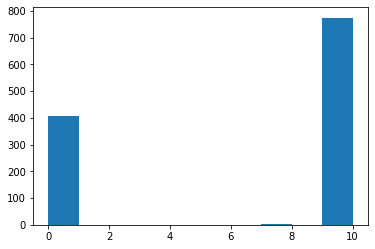

In [21]:
plt.hist([len(genes[a]) for a in genes])

In [24]:
with open("DeepHF_wt_paper_ready.tsv", "w") as oh:
    for a in genes:
        for b in genes[a]:
            oh.write(b)